In [1]:
import math
import rosbag2_py
import matplotlib.pyplot as plt

from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
from tf_transformations import euler_from_quaternion


In [2]:
bag_path = "/home/aman/ros_ws/src/1_not_pkg/aman_test/data/bag_file/rosbag2_2025_12_26-17_47_12_0.db3"

   # folder, not .db

reader = rosbag2_py.SequentialReader()

storage_options = rosbag2_py.StorageOptions(
    uri=bag_path,
    storage_id="sqlite3"
)
converter_options = rosbag2_py.ConverterOptions(
    input_serialization_format="cdr",
    output_serialization_format="cdr"
)

reader.open(storage_options, converter_options)

topic_types = {
    t.name: t.type for t in reader.get_all_topics_and_types()
}

odom_type = get_message(topic_types["/odom"])
scan_type = get_message(topic_types["/scan"])


[INFO] [1768024255.353409083] [rosbag2_storage]: Opened database '/home/aman/ros_ws/src/1_not_pkg/aman_test/data/bag_file/rosbag2_2025_12_26-17_47_12_0.db3' for READ_ONLY.


In [3]:
# odom trajectory
odom_t = []
xs = []
ys = []
yaws = []

# scan statistics (example: min range per scan)
scan_t = []
scan_min = []
scan_mean = []

latest_odom = None


In [4]:
while reader.has_next():
    topic, data, timestamp = reader.read_next()
    time_sec = timestamp * 1e-9  # ns → seconds

    # ---------- ODOM ----------
    if topic == "/odom":
        msg = deserialize_message(data, odom_type)

        pos = msg.pose.pose.position
        ori = msg.pose.pose.orientation

        _, _, yaw = euler_from_quaternion(
            [ori.x, ori.y, ori.z, ori.w]
        )

        latest_odom = (pos.x, pos.y, yaw)

        odom_t.append(time_sec)
        xs.append(pos.x)
        ys.append(pos.y)
        yaws.append(yaw)

    # ---------- SCAN ----------
    elif topic == "/scan" and latest_odom is not None:
        msg = deserialize_message(data, scan_type)

        valid_ranges = [r for r in msg.ranges if not math.isinf(r)]

        scan_t.append(time_sec)
        scan_min.append(min(valid_ranges))
        scan_mean.append(sum(valid_ranges) / len(valid_ranges))


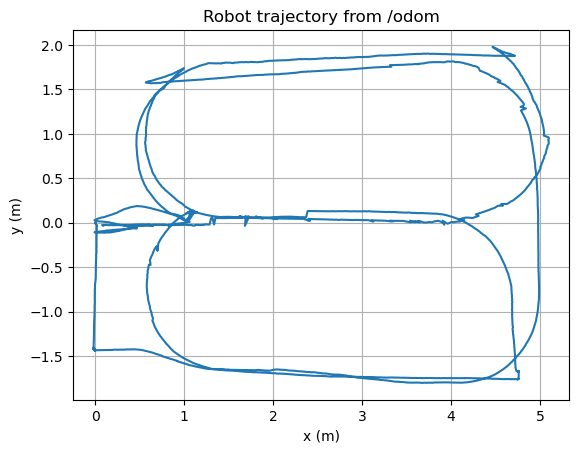

In [5]:
plt.figure()
plt.plot(xs, ys)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Robot trajectory from /odom")
plt.axis("equal")
plt.grid(True)
plt.show()


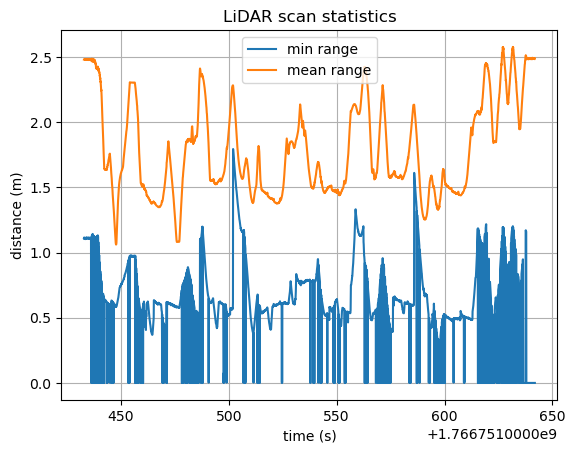

In [6]:
plt.figure()
plt.plot(scan_t, scan_min, label="min range")
plt.plot(scan_t, scan_mean, label="mean range")
plt.xlabel("time (s)")
plt.ylabel("distance (m)")
plt.title("LiDAR scan statistics")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
import math
import rosbag2_py
import matplotlib.pyplot as plt

from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
from tf_transformations import euler_from_quaternion


# ---------- open bag ----------
reader = rosbag2_py.SequentialReader()
reader.open(
    rosbag2_py.StorageOptions(uri=bag_path, storage_id="sqlite3"),
    rosbag2_py.ConverterOptions("cdr", "cdr")
)

topic_types = {t.name: t.type for t in reader.get_all_topics_and_types()}
odom_type = get_message(topic_types["/odom"])
scan_type = get_message(topic_types["/scan"])


# ---------- data containers ----------
xs, ys, yaws = [], [], []
global_x, global_y = [], []
latest_odom = None


# ---------- read bag ----------
while reader.has_next():
    topic, data, timestamp = reader.read_next()

    # ---------- ODOM ----------
    if topic == "/odom":
        msg = deserialize_message(data, odom_type)

        pos = msg.pose.pose.position
        ori = msg.pose.pose.orientation
        _, _, yaw = euler_from_quaternion(
            [ori.x, ori.y, ori.z, ori.w]
        )

        latest_odom = (pos.x, pos.y, yaw)
        xs.append(pos.x)
        ys.append(pos.y)
        yaws.append(yaw)

    # ---------- SCAN ----------
    elif topic == "/scan" and latest_odom is not None:
        msg = deserialize_message(data, scan_type)

        x_r, y_r, yaw = latest_odom
        angle = msg.angle_min

        for r in msg.ranges:
            if math.isinf(r) or math.isnan(r):
                angle += msg.angle_increment
                continue

            # local lidar point
            x_l = r * math.cos(angle)
            y_l = r * math.sin(angle)

            # transform to world frame
            x_w = x_r + (x_l * math.cos(yaw) - y_l * math.sin(yaw))
            y_w = y_r + (x_l * math.sin(yaw) + y_l * math.cos(yaw))

            global_x.append(x_w)
            global_y.append(y_w)

            angle += msg.angle_increment



[INFO] [1768024256.473965898] [rosbag2_storage]: Opened database '/home/aman/ros_ws/src/1_not_pkg/aman_test/data/bag_file/rosbag2_2025_12_26-17_47_12_0.db3' for READ_ONLY.


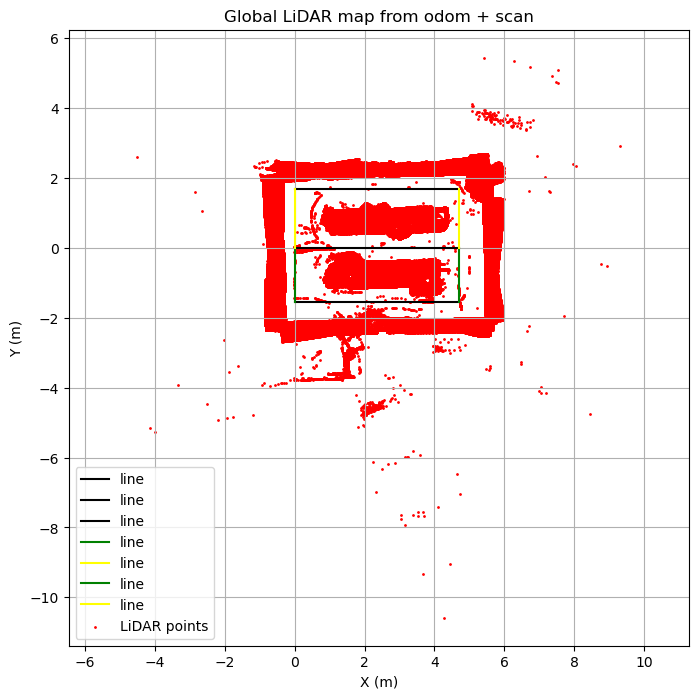

In [8]:

# ---------- plot ----------
plt.figure(figsize=(8, 8))

# horizontal
plt.plot([0, 4.7], [0, 0], label="line", c="black")
plt.plot([0, 4.7], [-1.54, -1.54], label="line", c="black")
plt.plot([0, 4.7], [1.7, 1.7], label="line", c="black")
# vertical
plt.plot([0, 0], [0, -1.54], label="line", c="green")
plt.plot([0, 0], [0, 1.7], label="line", c="yellow")
plt.plot([4.7, 4.7], [0, -1.54], label="line", c="green")
plt.plot([4.7, 4.7], [0, 1.7], label="line", c="yellow")

# plt.plot(xs, ys, label="Robot trajectory", linewidth=2)
plt.scatter(global_x, global_y, s=1, c="red", label="LiDAR points")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Global LiDAR map from odom + scan")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.show()
